# Simulate water molecule ground state energy with entanglement forging
## Case study: single-bond cleavage
Disclaimer: An end-to-end run of this notebook would take about 20 hours

In [1]:
import sys
from pathlib import Path

sys.path.append("../")

## Set up hop-gate
I have tested a few different combination of hop gates (see `hop_gate_1`, `hop_gate_2` and `hop_gate_3` implemented in `entanglement_simulation/circuits.py`)

Among the ones tested, `hop_gate_2` as given in [the original paper](https://arxiv.org/pdf/2104.10220.pdf) gives the best result. The following block shows the implemented hop-gate.

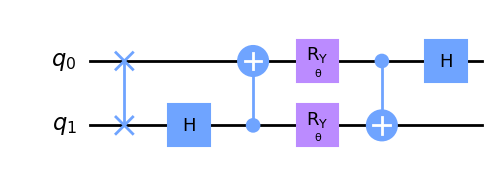

In [2]:
from qiskit.circuit import Parameter
from entanglement_simulation.circuits import hop_gate_2

theta = Parameter("θ")
hop_gate = hop_gate_2(theta)
hop_gate.draw(output="mpl")

## Set up ansatz
I set up the ansatz following Fig 2A of [the paper](https://arxiv.org/pdf/2104.10220.pdf). The ansatz given in Fig 5C has also been tested. The result appears to be identical as the ansatz given in Fig 2A.

In the following block, I show how the ansatz looks like.

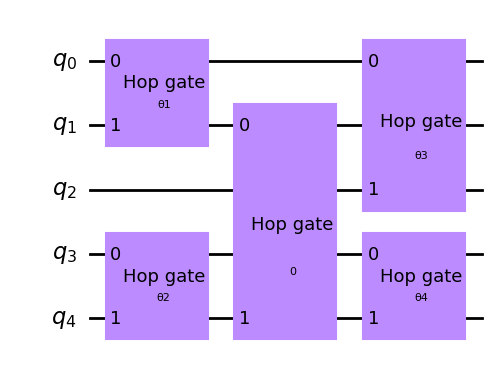

In [3]:
from entanglement_simulation.circuits import ansatz_circuit_1

ansatz = ansatz_circuit_1(hop_gate, theta)
ansatz.draw(output="mpl")

## Set up initial bitstrings
In the paper, the authors discussed the bitstrings used in their experiment as given in SM.11. Although in the paper, the authors demonstrate their results by freezing orbitals [0, 4]. I was only able to achieve better simulated energy results by freezing orbitals [0, 3].

Further hyperparameter search for frozen orbitals [0, 4] may yield better results than what I have obtained. Given the constraint of resources, I decide to go forward with frozen orbitals [0, 3].

In [4]:
from entanglement_simulation.data.constants import BITSTRINGS
from entanglement_simulation.scripts.entanglement_forge import reduce_bitstrings

# freeze 0th and 3rd orbitals
orbitals_to_reduce = [0, 3]
initial_bitstrings = reduce_bitstrings(BITSTRINGS, orbitals_to_reduce)
print(f"Bitstrings after freezing: {initial_bitstrings}")

Bitstrings after freezing: [[1, 1, 1, 0, 0], [0, 1, 1, 1, 0], [0, 1, 1, 0, 1], [1, 0, 1, 1, 0], [1, 0, 1, 0, 1], [1, 1, 1, 1, 0]]


## Set up hyperparameters for SPSA optimizer

I notice that when using SPSA optimizer, the chosen `c0` and `c1` parameters have an impact on the result significantly, especially at `R > 1.5 Angstrom`, so I decided to do a parameter search.

Due to limitation of computing resources, I fix the initial theta values necessary for the ansatz to `[np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]` and focus on only three bitstrings (k=3). Further hyperparameter tuning on the initial theta values and k=6 may give improvement to the results.

In [5]:
import numpy as np
from entanglement_simulation.utils.experiment_data import HyperParameters

# search best hyperparameters first with only 3 bitstrings
k=3

# set up hyperparameters for searching
spsa_c0s = np.arange(1, 11, 1) * np.pi
spsa_c1s = np.arange(1, 6, 1) * 0.1
initial_thetas_sets = [[np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]]

hyperparameters_sets = []
for spsa_c0 in spsa_c0s:
    for spsa_c1 in spsa_c1s:
        hyperparameters_sets.extend(
            HyperParameters(
                k=k,
                spsa_c0=spsa_c0,
                spsa_c1=spsa_c1,
                orbitals_to_reduce=orbitals_to_reduce,
                initial_thetas=initial_thetas,
            )
            for initial_thetas in initial_thetas_sets
        )
print(f"Hyperparameters structure: {hyperparameters_sets[0].to_dict()}")
print(f"Number of hyperparameters combinations: {len(hyperparameters_sets)}")

Hyperparameters structure: {'k': 3, 'spsa_c0': 3.141592653589793, 'spsa_c1': 0.1, 'orbitals_to_reduce': [0, 3], 'initial_thetas': [0.7853981633974483, 1.5707963267948966, 2.356194490192345, 3.141592653589793]}
Number of hyperparameters combinations: 50


## Set up experiment paths

In [6]:
from entanglement_simulation import EXPERIMENT_DIR

experiment_dir = EXPERIMENT_DIR / f"reduced_orbitals_{orbitals_to_reduce[0]}_{orbitals_to_reduce[1]}_k{k}"
experiment_dir.mkdir(exist_ok=True, parents=True)

## Run over all hyperparameter combinations
After preparing all combinations of hyperparameters, I run them through the preset experiment, `entanglement_simulation.scripts.entanglement_forge.run_one_entangled_forging_experiment`. In this function, a water molecule of different R_2 is constructed and then simulated by the ansatz demonstrated above. The ground state energy of this water molecule is then solved by the VQE algorithm.

In [7]:
from entanglement_simulation.scripts.entanglement_forge import run_one_entangled_forging_experiment

experiment_results = []
for idx, hyperparameters in enumerate(hyperparameters_sets):
    print(f"Experiment {idx + 1}/{len(hyperparameters_sets)}")
    experiment_result = run_one_entangled_forging_experiment(
        ansatz, hyperparameters, reduced_bitstrings=initial_bitstrings, target_dir=experiment_dir
    )
    experiment_results.append(experiment_result)

Experiment 1/50
HyperParameters(k=3, spsa_c0= 3.142, spsa_c1= 0.100, orbitals_to_reduce=[0, 3], initial_thetas=[0.7853981633974483, 1.5707963267948966, 2.356194490192345, 3.141592653589793])
Radius:  0.500; Ground State Energy: -74.76444
Radius:  0.722; Ground State Energy: -75.55772
Radius:  0.944; Ground State Energy: -75.69706
Radius:  1.167; Ground State Energy: -75.66674
Radius:  1.389; Ground State Energy: -75.59389
Radius:  1.611; Ground State Energy: -75.60321
Radius:  1.833; Ground State Energy: -75.57225
Radius:  2.056; Ground State Energy: -75.55638
Radius:  2.278; Ground State Energy: -75.55061
Radius:  2.500; Ground State Energy: -75.54733
Experiment 2/50
HyperParameters(k=3, spsa_c0= 3.142, spsa_c1= 0.200, orbitals_to_reduce=[0, 3], initial_thetas=[0.7853981633974483, 1.5707963267948966, 2.356194490192345, 3.141592653589793])
Radius:  0.500; Ground State Energy: -74.76493
Radius:  0.722; Ground State Energy: -75.55838
Radius:  0.944; Ground State Energy: -75.70026
Radius:

Radius:  0.500; Ground State Energy: -74.76698
Radius:  0.722; Ground State Energy: -75.56044
Radius:  0.944; Ground State Energy: -75.70355
Radius:  1.167; Ground State Energy: -75.67881
Radius:  1.389; Ground State Energy: -75.60654
Radius:  1.611; Ground State Energy: -75.57676
Radius:  1.833; Ground State Energy: -75.51379
Radius:  2.056; Ground State Energy: -75.38429
Radius:  2.278; Ground State Energy: -75.35139
Radius:  2.500; Ground State Energy: -75.30511
Experiment 42/50
HyperParameters(k=3, spsa_c0= 28.274, spsa_c1= 0.200, orbitals_to_reduce=[0, 3], initial_thetas=[0.7853981633974483, 1.5707963267948966, 2.356194490192345, 3.141592653589793])
Radius:  0.500; Ground State Energy: -74.76701
Radius:  0.722; Ground State Energy: -75.56044
Radius:  0.944; Ground State Energy: -75.70355
Radius:  1.167; Ground State Energy: -75.67885
Radius:  1.389; Ground State Energy: -75.60653
Radius:  1.611; Ground State Energy: -75.57917
Radius:  1.833; Ground State Energy: -75.51939
Radius: 

## Find the best hyperparameters
After results with all hyperparameters are created, I search for the hyperparameters that give a result closest to the classical ground state energy.

In [8]:
final_result_dir = experiment_dir / "best_fit/"
final_result_dir.mkdir(exist_ok=True, parents=True)
best_experiment = min(experiment_results, key=lambda x: x.mean_square_error_to_classical)
best_experiment.to_json(final_result_dir / "k3.json")
best_hyperparameters = best_experiment.hyperparameters
best_hyperparameters_dict = best_hyperparameters.to_dict()
print(f"Best hyperparameters: {best_hyperparameters_dict}")

Best hyperparameters: {'k': 3, 'spsa_c0': 15.707963267948966, 'spsa_c1': 0.5, 'orbitals_to_reduce': [0, 3], 'initial_thetas': [0.7853981633974483, 1.5707963267948966, 2.356194490192345, 3.141592653589793]}


## Simulate k=6 with the best hyperparameters
With this set of hyperparameters, I run the k=6 experiment.

In [11]:
best_hyperparameters_dict.pop("k")
best_k6_hyperparameters = HyperParameters(k=6, **best_hyperparameters_dict)
best_k6_result = run_one_entangled_forging_experiment(
    ansatz, best_k6_hyperparameters, reduced_bitstrings=initial_bitstrings, target_dir=experiment_dir
)
best_k6_result.to_json(final_result_dir / "k6.json")

HyperParameters(k=6, spsa_c0= 15.708, spsa_c1= 0.500, orbitals_to_reduce=[0, 3], initial_thetas=[0.7853981633974483, 1.5707963267948966, 2.356194490192345, 3.141592653589793])
Radius:  0.500; Ground State Energy: -74.76725
Radius:  0.722; Ground State Energy: -75.55894
Radius:  0.944; Ground State Energy: -75.70226
Radius:  1.167; Ground State Energy: -75.67771
Radius:  1.389; Ground State Energy: -75.60646
Radius:  1.611; Ground State Energy: -75.60840
Radius:  1.833; Ground State Energy: -75.58041
Radius:  2.056; Ground State Energy: -75.56310
Radius:  2.278; Ground State Energy: -75.55576
Radius:  2.500; Ground State Energy: -75.55432


## Plot results
The final results are plotted below.

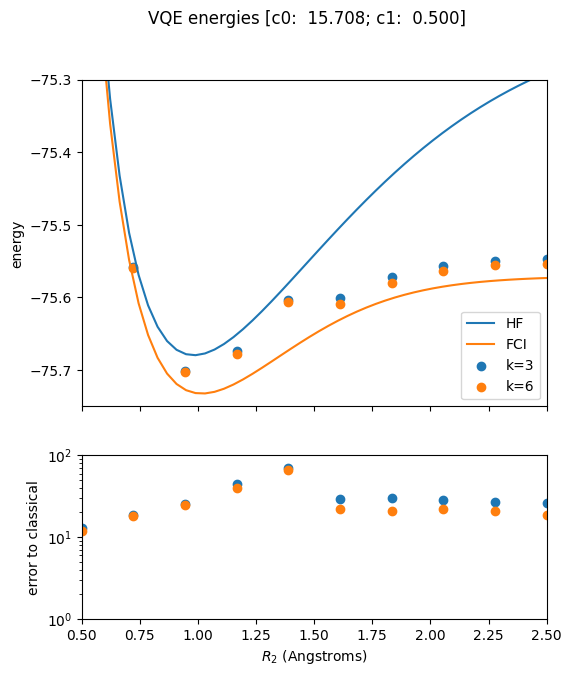

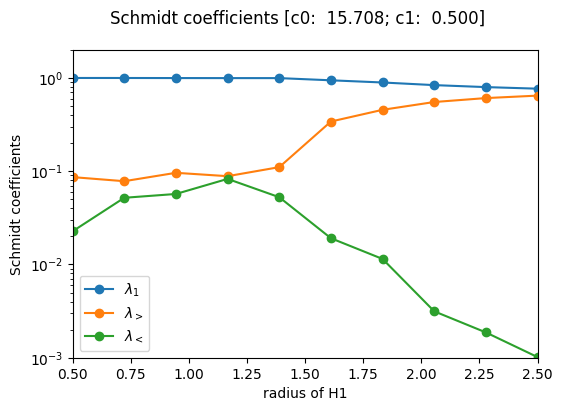

In [14]:
from entanglement_simulation.scripts.make_plots import plot_directory

figures = plot_directory(experiment_dir)

## Save figures

In [15]:
for fig_name, fig in figures.items():
    fig_path = experiment_dir / f"plots/{fig_name}.png"
    fig.savefig(fig_path)
    print(f"{fig_name} saved to {fig_path}")

fig_3b saved to /home/ronin/Cloud_Drive/AI_works/Projects/qunasys_assignment/notebooks/../experiments/reduced_orbitals_0_3_k3/plots/fig_3b.png
fig_4b saved to /home/ronin/Cloud_Drive/AI_works/Projects/qunasys_assignment/notebooks/../experiments/reduced_orbitals_0_3_k3/plots/fig_4b.png
